In [31]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.lines import Line2D


from utils.plot_config import set_matplotlib_config, blend_legend_color_with_alpha

set_matplotlib_config()
SAVE_DIR = Path(
    './figures/')
EXPECTILE_RUN = Path(
    '/net/argon/landclim/kraftb/machflow_engression/runs_quantiles/default/xval/fold_000/preds.zarr/')
ENGRESSION_RUN = Path(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/')

In [2]:
exp = xr.open_zarr(
    EXPECTILE_RUN
).isel(time=slice(365, None)).sel(time=slice('2017', '2022'))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod', 'P']].compute()

eng = xr.open_zarr(
    ENGRESSION_RUN
).sel(beta=0.67, esl=5, nl=100).sel(time=slice('2017', '2022'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod', 'P']].compute()


/tmp/ipykernel_12550/1402666582.py:172: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


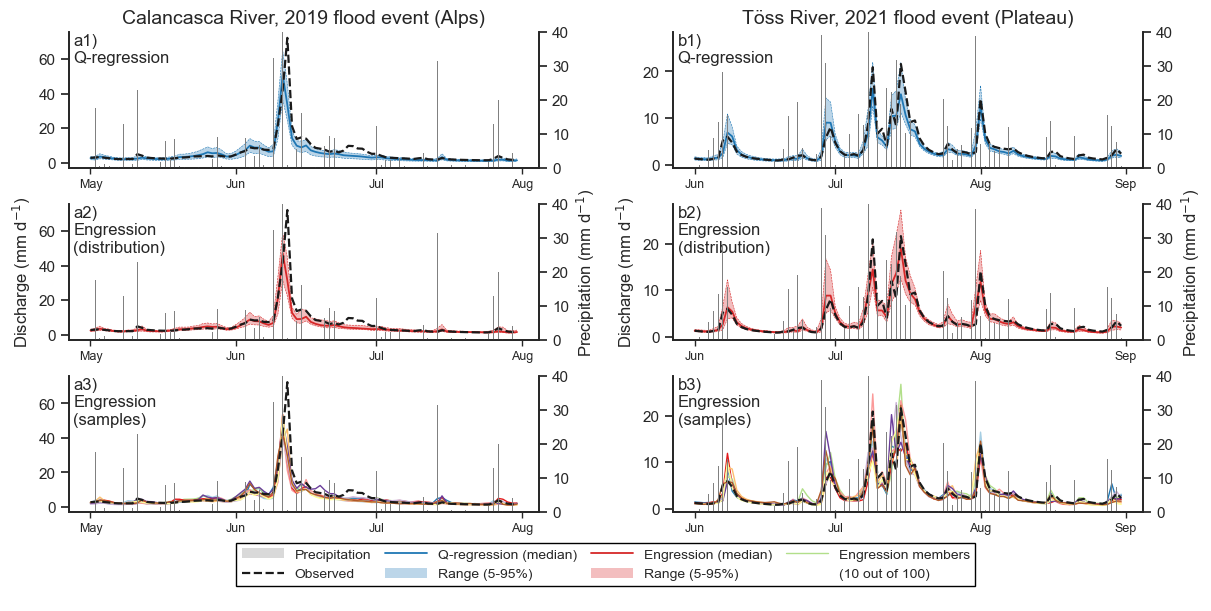

In [50]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 2, wspace=0.0, hspace=0., height_ratios=[1, 1, 1, 0.4])

ax00 = fig.add_subplot(gs[0, 0])
ax10 = fig.add_subplot(gs[1, 0], sharey=ax00)
ax20 = fig.add_subplot(gs[2, 0], sharey=ax00)

ax01 = fig.add_subplot(gs[0, 1])
ax11 = fig.add_subplot(gs[1, 1], sharey=ax01)
ax21 = fig.add_subplot(gs[2, 1], sharey=ax01)

axlegend = fig.add_subplot(gs[3, :])

ax_twin_ref = None

all_handles = []
all_labels = []

for p in range(2):
    #time = [slice('2021-06', '2021-08'), slice('2021-06', '2021-08')][p]
    #station = ['CHFO-0200', 'CHFO-0090'][p]

    time = [slice('2019-05', '2019-07'), slice('2021-06', '2021-08')][p]
    station = ['CHFO-0214', 'CHFO-0090'][p]

    axes = [ax00, ax10, ax20] if p == 0 else [ax01, ax11, ax21]

    for i, (name, ds) in enumerate(zip(['Q-regression', 'Engression'], [exp, eng])):

        ax = axes[i]

        color = ['tab:blue', 'tab:red'][i]

        ds_sel = ds.sel(station=station, time=time)
        ax.plot(
            ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=1.6, label='Observed' if i == 0 else None)

        if name == 'Engression':
            med = ds_sel.Qmm_mod.median('member')
            low = ds_sel.Qmm_mod.quantile(0.05, 'member')
            high = ds_sel.Qmm_mod.quantile(0.95, 'member')
        else:
            med = ds_sel.Qmm_mod.sel(member=0.5, method='nearest')
            low = ds_sel.Qmm_mod.sel(member=0.05, method='nearest')
            high = ds_sel.Qmm_mod.sel(member=0.95, method='nearest')

        ax.plot(ds_sel.time, med, lw=1.3, zorder=10, color=color, alpha=1.0, label=f'{name} (median)')
        ax.fill_between(ds_sel.time, low, high, ec='none', alpha=0.3, zorder=-10, fc=color, label='Range (5-95%)')
        ax.plot(ds_sel.time, low, lw=0.4, zorder=10, ls='--', color=color)
        ax.plot(ds_sel.time, high, lw=0.4, zorder=10, ls='--', color=color)

        ax_twin = ax.twinx()
        ax_twin.bar(
            ds_sel.time, ds_sel.P, fc='0.5', ec='none', alpha=1.0, label='Precipitation' if i == 0 else None, zorder=-10, width=0.2)

        ax.spines[['top']].set_visible(False)
        ax_twin.spines[['top']].set_visible(False)

        h0, l0 = ax.get_legend_handles_labels()
        h1, l1 = ax_twin.get_legend_handles_labels()

        handles = h1 + h0
        labels = l1 + l0

        if p == 0:
            all_handles.extend(handles)
            all_labels.extend(labels)

        if i == 1:
            ax.set_ylabel('Discharge (mm d$^{-1}$)')
            ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')
        else:
            ax.set_ylabel('')
            ax_twin.set_ylabel('')

        ax.set_rasterization_zorder(-5)

        ax_twin.set_ylim(0, 40)

    ax = axes[2]

    color = 'tab:red'

    ds_sel = eng.sel(station=station, time=time)
    ax.plot(ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=1.6)

    med = ds_sel.Qmm_mod.mean('member')
    low = ds_sel.Qmm_mod.quantile(0.05, 'member')
    high = ds_sel.Qmm_mod.quantile(0.95, 'member')

    colormap = cm.Paired
    num_members = 10
    colors = [colormap(i / (num_members - 1)) for i in range(num_members)]
    for m in range(num_members):
        ax.plot(
            ds_sel.time,
            ds_sel.Qmm_mod.isel(member=m),
            zorder=5,
            color=colors[m],
            ls='-',
            lw=1.,
            label=f'Engression members' if m == 2 else None
        )

    ax_twin = ax.twinx()
    ax_twin.bar(ds_sel.time, ds_sel.P, fc='0.5', ec='none', alpha=1.0, zorder=-10, width=0.2)

    ax.spines[['top']].set_visible(False)
    ax_twin.spines[['top']].set_visible(False)

    h0, l0 = ax.get_legend_handles_labels()
    h1, l1 = ax_twin.get_legend_handles_labels()
    handles = h1 + h0 + [Line2D([], [], linestyle='none', label='_nolegend_')]
    labels = l1 + l0 + [f'({num_members} out of 100)']

    if p == 0:
        all_handles.extend(handles)
        all_labels.extend(labels)


    ax.set_ylabel('')
    ax_twin.set_ylabel('')

    ax.set_rasterization_zorder(-5)

    ax.set_xlabel(['2019', '2021'][p])

    ax_twin.set_ylim(0, 40)
    l = ['a', 'b'][p]
    for ax, label in zip(axes, [f'{l}1)', f'{l}2)', f'{l}3)']):
        # ax.annotate(label, xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
        #             ha='left', va='top', color='k')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))  # newline to place it below

        # Set minor ticks to months
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

        # Show both major and minor tick labels
        ax.tick_params(axis='x', which='major', labelsize=10)
        ax.tick_params(axis='x', which='minor', labelsize=9)

legend = axlegend.legend(
    all_handles, all_labels,
    frameon=True,
    # loc='lower center',
    # bbox_to_anchor=(0.5, 1),
    # ncol=2 if i == 0 else 3,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=4,
    columnspacing=1,
    alignment='left',
    handlelength=3)
blend_legend_color_with_alpha(legend=legend, indices=[0, 3, 5], alpha=0.3)

axlegend.axis('off')

ax00.set_title('Calancasca River, 2019 flood event (Alps)', fontsize=14)
ax01.set_title('Töss River, 2021 flood event (Plateau)', fontsize=14)

ax00.text(0.01, 0.99, 'a1)\nQ-regression', ha='left', va='top', transform=ax00.transAxes, fontsize=12)
ax10.text(0.01, 0.99, 'a2)\nEngression\n(distribution)', ha='left', va='top', transform=ax10.transAxes, fontsize=12)
ax20.text(0.01, 0.99, 'a3)\nEngression\n(samples)', ha='left', va='top', transform=ax20.transAxes, fontsize=12)

ax01.text(0.01, 0.99, 'b1)\nQ-regression', ha='left', va='top', transform=ax01.transAxes, fontsize=12)
ax11.text(0.01, 0.99, 'b2)\nEngression\n(distribution)', ha='left', va='top', transform=ax11.transAxes, fontsize=12)
ax21.text(0.01, 0.99, 'b3)\nEngression\n(samples)', ha='left', va='top', transform=ax21.transAxes, fontsize=12)

fig.autofmt_xdate()
fig.savefig(SAVE_DIR / 'time_series.eps', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2383/4073388209.py:142: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


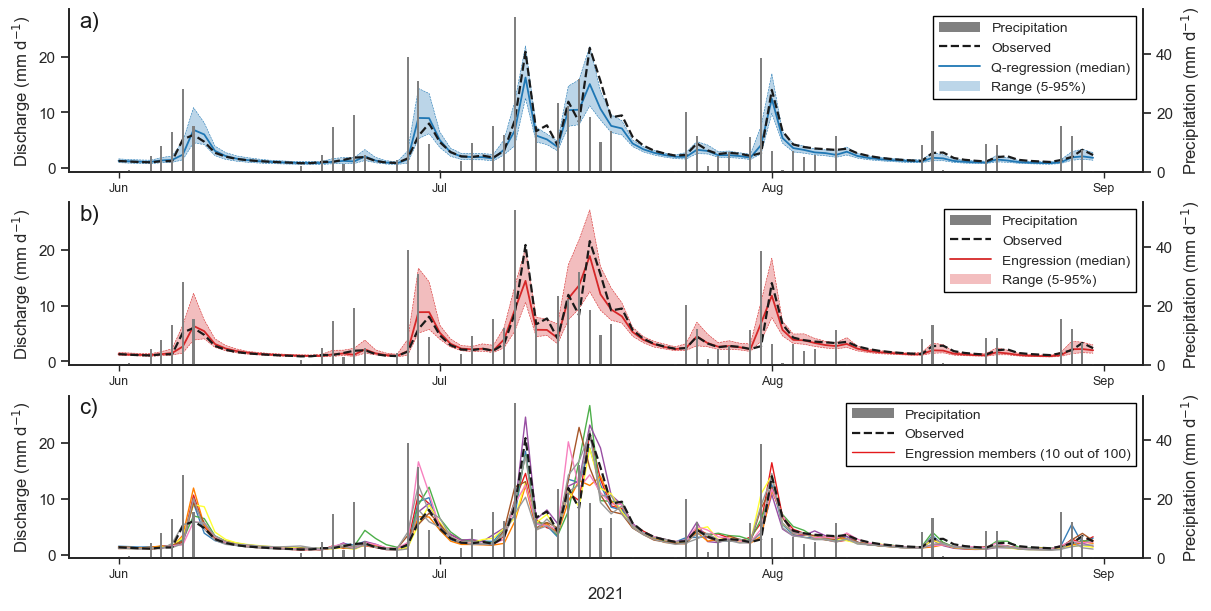

In [ ]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(3, 1, wspace=0.0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharey=ax0)
ax2 = fig.add_subplot(gs[2], sharey=ax0)

time = slice('2021-06', '2021-08')
station = 'CHFO-0090'

for i, (name, ds) in enumerate(zip(['Q-regression', 'Engression'], [exp, eng])):

    ax = [ax0, ax1][i]

    color = ['tab:blue', 'tab:red'][i]

    ds_sel = ds.sel(station=station, time=time)
    ax.plot(ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=1.6, label='Observed')

    if name == 'Engression':
        med = ds_sel.Qmm_mod.median('member')
        low = ds_sel.Qmm_mod.quantile(0.05, 'member')
        high = ds_sel.Qmm_mod.quantile(0.95, 'member')
    else:
        med = ds_sel.Qmm_mod.sel(member=0.5, method='nearest')
        low = ds_sel.Qmm_mod.sel(member=0.05, method='nearest')
        high = ds_sel.Qmm_mod.sel(member=0.95, method='nearest')

    ax.plot(ds_sel.time, med, lw=1.3, zorder=10, color=color, alpha=1.0, label=f'{name} (median)')
    ax.fill_between(ds_sel.time, low, high, ec='none', alpha=0.3, zorder=-10, fc=color, label='Range (5-95%)')
    ax.plot(ds_sel.time, low, lw=0.4, zorder=10, ls='--', color=color)
    ax.plot(ds_sel.time, high, lw=0.4, zorder=10, ls='--', color=color)

    ax_twin = ax.twinx()
    ax_twin.bar(ds_sel.time, ds_sel.P, fc='0.5', ec='none', alpha=1.0, label='Precipitation', zorder=-10, width=0.2)

    ax.spines[['top']].set_visible(False)
    ax_twin.spines[['top']].set_visible(False)

    h0, l0 = ax.get_legend_handles_labels()
    h1, l1 = ax_twin.get_legend_handles_labels()

    handles = h1 + h0
    labels = l1 + l0

    legend = ax.legend(
        handles, labels,
        frameon=True,
        # loc='lower center',
        # bbox_to_anchor=(0.5, 1),
        # ncol=2 if i == 0 else 3,
        loc='upper right',
        bbox_to_anchor=(1.0, 1.0),
        ncol=1,
        columnspacing=1,
        handlelength=3)
    blend_legend_color_with_alpha(legend=legend, indices=[3], alpha=0.3)
    # ax.set_ylabel('Discharge (mm d$^{-1}$)')
    # ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

    # if i == 0:
    #     ax_twin.set_ylabel('')
    #     ax_twin.set_yticklabels([])
    # else:
    #     ax.set_ylabel('')

    ax.set_ylabel('Discharge (mm d$^{-1}$)')
    ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

    ax.set_rasterization_zorder(-5)

ax = ax2

color = 'tab:red'

ds_sel = eng.sel(station=station, time=time)
ax.plot(ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=1.6, label='Observed')

med = ds_sel.Qmm_mod.mean('member')
low = ds_sel.Qmm_mod.quantile(0.05, 'member')
high = ds_sel.Qmm_mod.quantile(0.95, 'member')

colormap = cm.Set1
num_members = 10
colors = [colormap(i / (num_members - 1)) for i in range(num_members)]
for m in range(num_members):
    ax.plot(
        ds_sel.time,
        ds_sel.Qmm_mod.isel(member=m),
        zorder=5,
        color=colors[m],
        ls='-',
        lw=1.,
        label=f'Engression members ({num_members} out of 100)' if m == 0 else None
    )

ax_twin = ax.twinx()
ax_twin.bar(ds_sel.time, ds_sel.P, fc='0.5', ec='none', alpha=1.0, label='Precipitation', zorder=-10, width=0.2)

ax.spines[['top']].set_visible(False)
ax_twin.spines[['top']].set_visible(False)

h0, l0 = ax.get_legend_handles_labels()
h1, l1 = ax_twin.get_legend_handles_labels()
handles = h1 + h0
labels = l1 + l0

ax.legend(
    handles, labels,
    frameon=True,
    # loc='lower center',
    # bbox_to_anchor=(0.5, 1),
    # ncol=2 if i == 0 else 3,
    loc='upper right',
    bbox_to_anchor=(1.0, 1),
    ncol=1,
    columnspacing=1,
    handlelength=3)

ax.set_ylabel('Discharge (mm d$^{-1}$)')
ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

ax.set_rasterization_zorder(-5)

for ax, label in zip([ax0, ax1, ax2], ['a)', 'b)', 'c)']):
    ax.annotate(label, xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
                ha='left', va='top', color='k')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))  # newline to place it below

    # Set minor ticks to months
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    # Show both major and minor tick labels
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='x', which='minor', labelsize=9)

ax.set_xlabel('2021')

fig.autofmt_xdate()
fig.savefig(SAVE_DIR / 'time_series_legacy.eps', dpi=300, bbox_inches='tight')